In [1]:
import matplotlib.pyplot as plt

import matplotlib.image as img

import numpy as np

import os

import pandas as pd

import pickle

import tensorflow as tf

import tensorflow.keras.backend as K

from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D

from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

from tensorflow.keras.optimizers import SGD,Adam

from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras import metrics

2024-11-06 16:01:29.470159: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Processing

In [2]:
num_classes = 251

width, height = 224, 224

train_dir = '/kaggle/input/ifood-2019/ifood-2019-fgvc6/organized_train_set'

val_dir = '/kaggle/input/ifood-2019/ifood-2019-fgvc6/organized_val_set'

test_dir = '/kaggle/input/ifood-2019/ifood-2019-fgvc6/test_set'

batch_size = 32

In [3]:
train_datagen = ImageDataGenerator(

    rescale=1. / 255,

    shear_range=0.2,

    rotation_range=30,

    width_shift_range=0.2,

    height_shift_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

)



validation_datagen = ImageDataGenerator(rescale=1. / 255)

In [4]:
train_set = train_datagen.flow_from_directory(

    train_dir,

    target_size=(width, height),

    batch_size=batch_size,

    class_mode='categorical',

)



val_set = validation_datagen.flow_from_directory(

    val_dir,

    target_size=(width, height),

    batch_size=batch_size,

    class_mode='categorical',

)

Found 118475 images belonging to 251 classes.
Found 11994 images belonging to 251 classes.


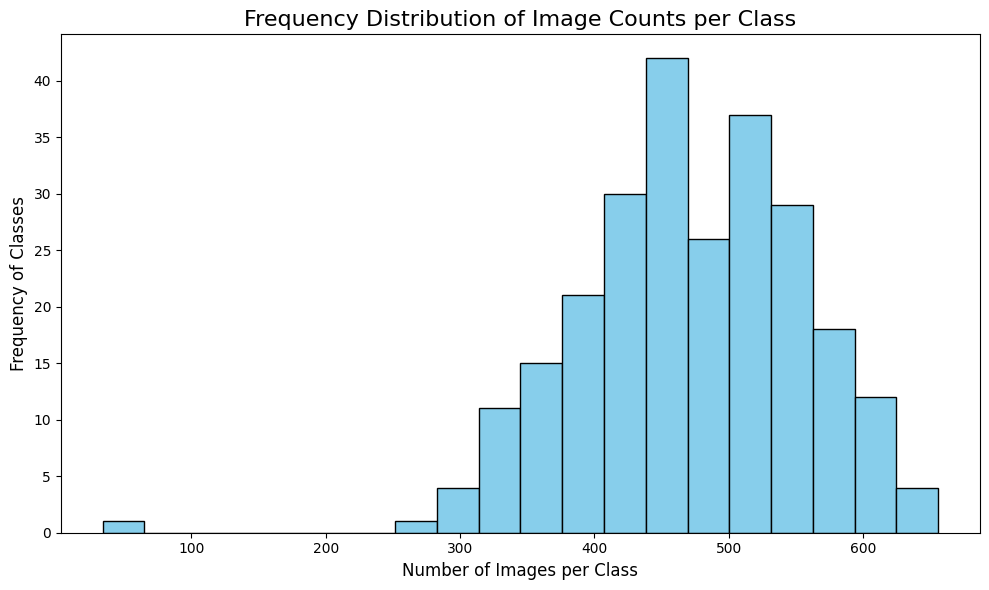

In [5]:
# Get a list of all class directories

class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Count the number of images in each class directory

class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in class_dirs]

# Plot the frequency of image counts

plt.figure(figsize=(10, 6))

plt.hist(class_counts, bins=20, color='skyblue', edgecolor='black')


plt.title('Frequency Distribution of Image Counts per Class', fontsize=16)

plt.xlabel('Number of Images per Class', fontsize=12)

plt.ylabel('Frequency of Classes', fontsize=12)

plt.tight_layout()

plt.show()

In [6]:
from sklearn.utils import class_weight

class_labels = train_set.classes  # Labels for each image in the training set

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',

                                                  classes=np.unique(class_labels),

                                                  y=class_labels)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.7456744900335467, 1: 0.8822653311985702, 2: 1.3882704476212795, 3: 1.1002609608187297, 4: 0.8956583533040513, 5: 0.8724805031261277, 6: 1.5733731739707835, 7: 1.0283484797194664, 8: 1.0000253224390574, 9: 0.9613278048701325, 10: 0.9346771330519507, 11: 1.0465896944373283, 12: 1.0238870980287094, 13: 0.8194651947764497, 14: 1.1028316639982128, 15: 0.9237024504720842, 16: 0.9007861683038837, 17: 1.0875851432977766, 18: 0.9874727033289437, 19: 0.8194651947764497, 20: 0.9440239043824701, 21: 0.7650112677329579, 22: 0.816629675071341, 23: 0.7712613597895998, 24: 0.7788976108766255, 25: 0.839878918489742, 26: 1.151248663881061, 27: 1.0150794670779248, 28: 0.89736112583885, 29: 0.8773456360431878, 30: 1.0727544367982615, 31: 0.9237024504720842, 32: 1.0351139302439365, 33: 1.279165182090068, 34: 0.8295464889125397, 35: 1.1106163580970236, 36: 0.9025085127939485, 37: 1.0776528588840983, 38: 1.0064220729024203, 39: 1.1158674992700592, 40: 1.2041121229368241, 41: 1.0776528588

# Model Callbacks

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint_dir = '/kaggle/working/Dense_Model_Tests'

os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks

Callbacks = [

    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'Created_Dense_Best.keras'),

                    save_best_only=True,

                    monitor='val_loss',

                    mode='min',

                    verbose=1),  # Save the best model based on validation loss

    EarlyStopping(monitor='val_loss',

                  patience=10,  # Stop training after 10 epochs without improvement

                  mode='min',

                  verbose=1,

                  restore_best_weights=True),

    ReduceLROnPlateau(monitor='val_loss',

                      factor=0.2,  # Reduce learning rate by 20%

                      patience=3,  # Reduce if no improvement after 3 epochs

                      mode='min',

                      verbose=1),

]

In [8]:
from keras.callbacks import Callback
from datetime import datetime

class SaveHistory(Callback):

    def __init__(self, save_path):

        super(SaveHistory, self).__init__()

        self.save_path = save_path

        # Load history if exists
        if os.path.exists(self.save_path):

            with open(self.save_path, 'rb') as f:
                self.history = pickle.load(f)

        else:
            self.history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': [], 'precision': [], 'val_precision': [], 'recall': [], 'val_recall': []}

    def on_epoch_end(self, epoch, logs=None):
        # Append new logs to the history
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['precision'].append(logs.get('precision'))
        self.history['val_precision'].append(logs.get('val_precision'))
        self.history['recall'].append(logs.get('recall'))
        self.history['val_recall'].append(logs.get('val_recall'))

        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(self.save_path), exist_ok=True)
        
        # Save history to a file
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

        print(f"Epoch {epoch+1} history saved to {self.save_path}")


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
history_save_path = f'/kaggle/working/Dense_Model_Data/created_Dense_train_history_{timestamp}.pkl'

# Create the callback
history_callback = SaveHistory(save_path=history_save_path)


# DenseNet201 Testing

In [ ]:
resnet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False,input_shape=(width,width,3))

for layer in resnet.layers[:100]:

    layer.trainable=False

In [ ]:
x = resnet.output

x = GlobalAveragePooling2D()(x)

x = Dense(300,activation='relu')(x)

x = Dropout(0.5)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_set,

        validation_data = val_set,

        epochs=8,

        verbose=1,

        class_weight= class_weights_dict,

        callbacks=[Callbacks, history_callback]

         )

In [ ]:
model.summary()

In [ ]:
# Evaluate the model

score = model.evaluate(val_set, verbose=1)

print("\nTest accuracy:", score[1])

Collab Auto Ends Runtime After 3.5 HRS, Data Logged After Each Epoch So We Load

All Files, Combine, And Plot Data

In [ ]:
# Load the history from all sessions

with open('/content/drive/MyDrive/resnet_training_history.pkl', 'rb') as file:

    history1 = pickle.load(file)



with open('/content/drive/MyDrive/resnet_training_history_2.pkl', 'rb') as file:

    history2 = pickle.load(file)



with open('/content/drive/MyDrive/resnet_training_history_3.pkl', 'rb') as file:

    history3 = pickle.load(file)



# Combine the histories

combined_history = {}

for key in history1.keys():

    combined_history[key] = history1[key] + history2[key] + history3[key]





epochs = np.arange(1, len(combined_history['loss']) + 1)



# Plot training & validation accuracy values

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

plt.plot(epochs, combined_history['accuracy'], label='Training Accuracy')

plt.plot(epochs, combined_history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(loc='upper left')



# Plot training & validation loss values

plt.subplot(1, 2, 2)

plt.plot(epochs, combined_history['loss'], label='Training Loss')

plt.plot(epochs, combined_history['val_loss'], label='Validation Loss')

plt.title('Model Loss')

plt.ylabel('Loss')

plt.xlabel('Epoch')

plt.legend(loc='upper left')



plt.tight_layout()

plt.show()


In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/resnet_best_model251.keras')

In [ ]:
class_labels = list(val_set.class_indices.keys())



test_images, test_labels = next(val_set)

predictions = loaded_model.predict(test_images)



for i in range(20):

    predicted_label_index = np.argmax(predictions[i])

    predicted_label = class_labels[predicted_label_index]

    true_label_index = np.argmax(test_labels[i])

    true_label = class_labels[true_label_index]



    plt.figure(figsize=(2,2))

    plt.imshow(test_images[i])

    plt.title(f"Predicted Label: {predicted_label}\nTrue Label: {true_label}")

    plt.axis('off')

    plt.show()


# Creating DenseNet and Testing

In [9]:
import tensorflow as tf

from tensorflow.keras import layers, models



def dense_block(x, growth_rate, num_layers):

    for i in range(num_layers):

        output = layers.BatchNormalization()(x)

        output = layers.ReLU()(output)

        output = layers.Conv2D(growth_rate, (3, 3), padding='same')(output)



        # Concatenate input with the new output

        x = layers.concatenate([x, output])

    return x



def transition_layer(x, reduction):

    filters = int(x.shape[-1] * reduction)  # Reduce number of filters

    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters, (1, 1), padding='same')(x)

    x = layers.AveragePooling2D((2, 2), strides=2)(x)  # Downsample

    return x



def build_densenet(input_shape=(224, 224, 3), num_classes=251, growth_rate=32):

    inputs = tf.keras.Input(shape=input_shape)



    # Initial convolution

    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)

    x = layers.BatchNormalization()(x)

    x = layers.ReLU()(x)

    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)





    x = dense_block(x, growth_rate, 6)

    x = transition_layer(x, 0.5)



    x = dense_block(x, growth_rate, 12)

    x = transition_layer(x, 0.5)



    x = dense_block(x, growth_rate, 24)

    x = transition_layer(x, 0.5)



    x = dense_block(x, growth_rate, 16)



    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(num_classes, activation='softmax')(x)



    model = models.Model(inputs, x)

    return model

model = build_densenet()

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     18,464 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     27,680 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 56, 56,    │          0 │ concatenate[0][0… │
│ (Concatenate)       │ 128)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,896 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56, 56,    │          0 │ concatenate_1[0]

 Total params: 10,168,891 (38.79 MB)

 Trainable params: 10,102,139 (38.54 MB)

 Non-trainable params: 66,752 (260.75 KB)

In [10]:
model.compile(optimizer='adam',

              loss='categorical_crossentropy',

              metrics=['accuracy', 'Precision', 'Recall'])



history = model.fit(train_set,

                      validation_data=val_set,

                      epochs=30,

                      verbose=1,

                      class_weight=class_weights_dict,

                      callbacks=[Callbacks, history_callback])

results = model.evaluate(val_set, verbose=1)

# Extracting metrics
loss = results[0]
accuracy = results[1]
precision = results[2]
recall = results[3]

print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
print('\nNew Test Below:\n')


y_true = val_set.classes

prediction = model.predict(val_set)
y_pred = np.argmax(prediction, axis=1)

label_map = {}
with open('/kaggle/input/ifood-2019/ifood-2019-fgvc6/class_list.txt', 'r') as f:
    for line in f:
        numerical_label, actual_label = line.strip().split()
        label_map[int(numerical_label)] = actual_label

# Convert numerical labels to actual labels
y_true = [label_map[label] for label in y_true]
y_pred = [label_map[label] for label in y_pred]

# Generate the classification report
report = classification_report(y_true, y_pred,zero_division=1)



print(report)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730745211.135323     109 service.cc:145] XLA service 0x7bf8e4003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730745211.135380     109 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730745282.226439     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - Precision: 0.0157 - Recall: 1.7248e-04 - accuracy: 0.0135 - loss: 5.8742
Epoch 1: val_loss improved from inf to 5.46246, saving model to /kaggle/working/Dense_Model_Tests/Created_Dense_Best.keras
Epoch 1 history saved to /kaggle/working/Dense_Model_Data/created_Dense_train_history_20241104_183214.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 2211s 567ms/step - Precision: 0.0157 - Recall: 1.7249e-04 - accuracy: 0.0135 - loss: 5.8740 - val_Precision: 0.1500 - val_Recall: 7.5038e-04 - val_accuracy: 0.0268 - val_loss: 5.4625 - learning_rate: 0.0010
Epoch 2/20
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - Precision: 0.3816 - Recall: 0.0011 - accuracy: 0.0631 - loss: 4.7265
Epoch 2: val_loss improved from 5.46246 to 4.78478, saving model to /kaggle/working/Dense_Model_Tests/Created_Dense_Best.keras
Epoch 2 history saved to /kaggle/working/Dense_Model_Data/created_Dense_train_history_20241104_183214.pkl
3703/3703 ━━━━━━━━━━━━━━━━━━━━ 1786s 481ms/step - Pre

"\n\n\n\nloaded_model = tf.keras.models.load_model('/content/drive/MyDrive/CNN_Model_Tests/Created_Dense_Best.keras')\n\n\n\nhistory = loaded_model.fit(train_set,\n\n                      validation_data=val_set,\n\n                      epochs=6,\n\n                      verbose=1,\n\n                      class_weight=class_weights_dict,\n\n                      callbacks=[Callbacks, history_callback])\n\n\n\nfrom google.colab import runtime\n\nruntime.unassign()\n"

In [20]:
predictions = model.predict(val_set)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = val_set.classes

# Calculate metrics
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=val_set.class_indices.keys()))

# Print the calculated metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

375/375 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.00      0.00      0.00        61
          10       0.00      0.00      0.00        48
         100       0.00      0.00      0.00        47
         101       0.00      0.00      0.00        36
         102       0.00      0.00      0.00        46
         103       0.00      0.00      0.00        42
         104       0.00      0.00      0.00        40
         105       0.00      0.00      0.00        51
         106       0.00      0.00      0.00        45
         107       0.00      0.00      0.00        48
         108       0.00      0.00      0.00        36
         109       0.00      0.00      0.00        35
          11       0.00      0.00      0.00        47
         110       0.02      0.02      0.02        55
         111       0.00      0.00      0.00        60
         112       0.00      0.00     

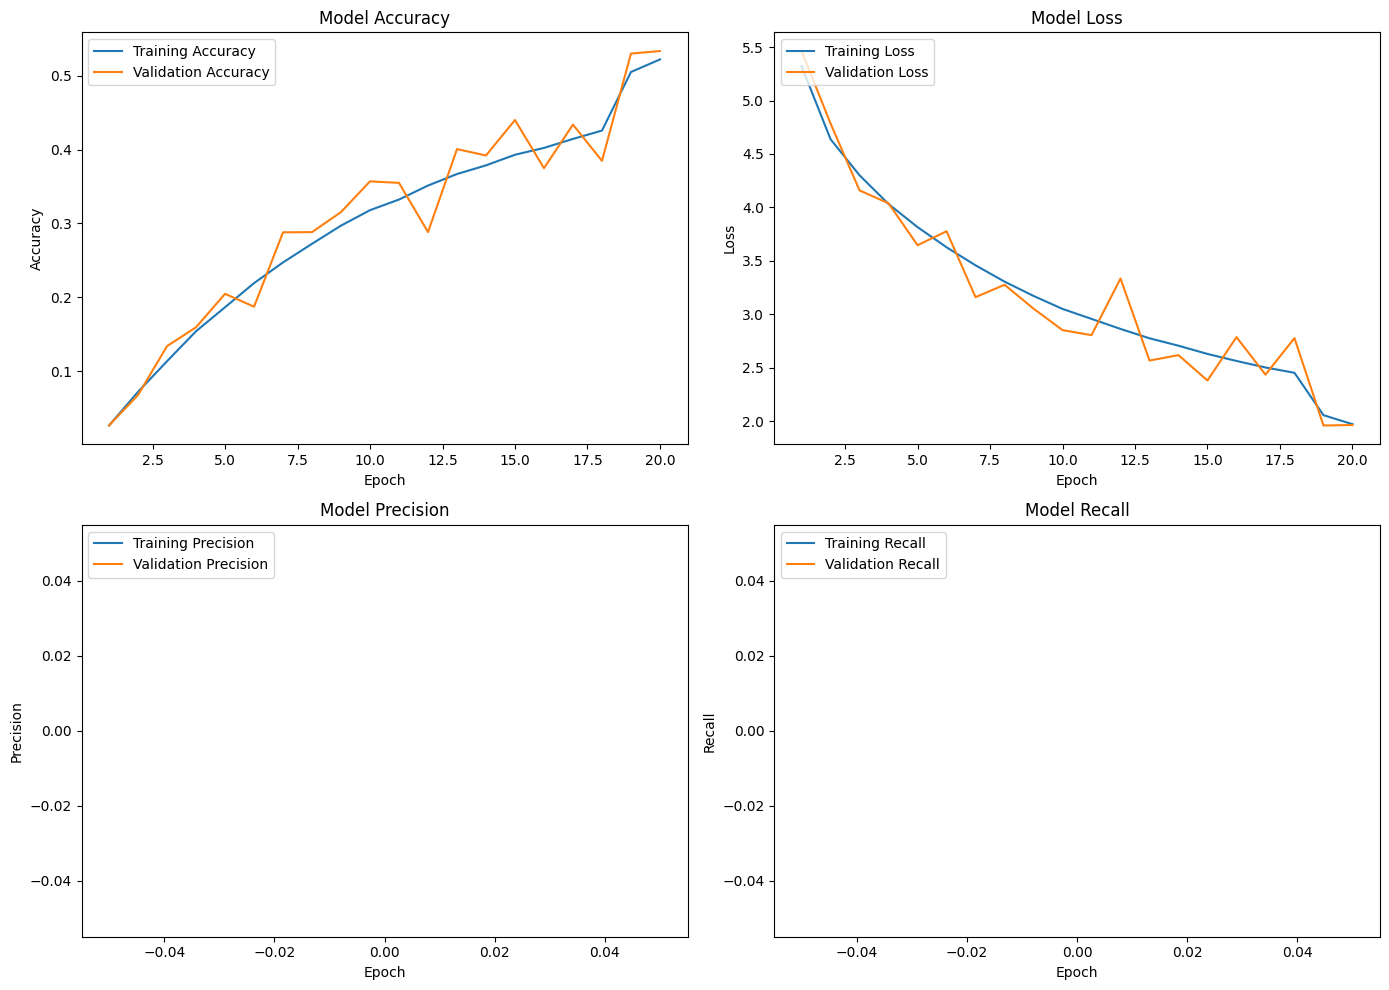

In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the history from the file
with open('/kaggle/working/Dense_Model_Data/created_Dense_train_history_20241104_183214.pkl', 'rb') as file:
    history1 = pickle.load(file)

# Define epochs
epochs = np.arange(1, len(history1['loss']) + 1)

# Set up a larger figure with 2 rows and 2 columns
plt.figure(figsize=(14, 10))

# Plot training & validation accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, history1['accuracy'], label='Training Accuracy')
plt.plot(epochs, history1['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss
plt.subplot(2, 2, 2)
plt.plot(epochs, history1['loss'], label='Training Loss')
plt.plot(epochs, history1['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation precision
plt.subplot(2, 2, 3)
plt.plot(epochs, history1['precision'], label='Training Precision')
plt.plot(epochs, history1['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation recall
plt.subplot(2, 2, 4)
plt.plot(epochs, history1['recall'], label='Training Recall')
plt.plot(epochs, history1['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [18]:
with open('/kaggle/working/Dense_Model_Data/created_Dense_train_history_20241104_183214.pkl', 'rb') as file:
    data = pickle.load(file)

print(f"Data type: {type(data)}")
if isinstance(data, dict):
    print("Keys:", data.keys())


print("\nData:\n", data)

Data type: <class 'dict'>
Keys: dict_keys(['accuracy', 'val_accuracy', 'loss', 'val_loss', 'precision', 'val_precision', 'recall', 'val_recall'])

Complete Data:
 {'accuracy': [0.026638532057404518, 0.0722430869936943, 0.11363578587770462, 0.15417598187923431, 0.18662165105342865, 0.2192445695400238, 0.24727579951286316, 0.2724541127681732, 0.29705846309661865, 0.3179151713848114, 0.332323282957077, 0.3512302041053772, 0.36683687567710876, 0.3785524368286133, 0.39288458228111267, 0.4021354615688324, 0.41431525349617004, 0.4255918860435486, 0.5048660039901733, 0.5218231678009033], 'val_accuracy': [0.02676338143646717, 0.06795064359903336, 0.13406702876091003, 0.1595797836780548, 0.2047690451145172, 0.18734367191791534, 0.28797730803489685, 0.2882274389266968, 0.3154076933860779, 0.3569284677505493, 0.3548440933227539, 0.28831082582473755, 0.4005335867404938, 0.3919459581375122, 0.43988659977912903, 0.37477073073387146, 0.4336334764957428, 0.38469234108924866, 0.5297648906707764, 0.53318